# Principal Component Analysis (PCA)
by Marc Deisenroth and Yicheng Luo

We will implement the PCA algorithm using the projection perspective. We will first implement PCA, then apply it to the MNIST digit dataset.

## Learning objectives
1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets

Let's first import the packages we need for this week.

In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact

In [2]:
# PACKAGE: DO NOT EDIT THIS CELL
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
%matplotlib inline

Now, let's plot a digit from the dataset:

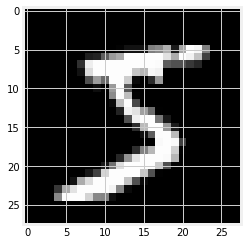

In [4]:
plt.figure(figsize=(4,4))
plt.imshow(images.iloc[0].values.reshape(28,28), cmap='gray');

Before we implement PCA, we will need to do some data preprocessing. In this assessment, some of them 
will be implemented by you, others we will take care of. However, when you are working on real world problems, you will need to do all these steps by yourself.

The preprocessing steps we will do are
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.
2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

## 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

In [5]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std

def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    eigvals, eigvecs = np.linalg.eig(S)
    k = np.argsort(eigvals)[::-1]
    return eigvals[k], eigvecs[:,k]

def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    return (B @ np.linalg.inv(B.T @ B) @ B.T)

def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    # first perform normalization on the digits so that they have zero mean and unit variance
    # Then compute the data covariance matrix S
    S = 1.0/len(X) * np.dot(X.T, X)

    # Next find eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eig(S)

    # find indices for the largest eigenvalues, use them to sort the eigenvalues and 
    # corresponding eigenvectors. Take a look at the documenation fo `np.argsort` 
    # (https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html),
    # which might be useful
    eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]

    # dimensionality reduction of the original data
    B = np.real(eig_vecs)
    # Z = X.T.dot(W)
    # reconstruct the images from the lower dimensional representation
    reconst = (projection_matrix(B) @ X.T)
    return reconst.T


In [9]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.values.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

In [10]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())

1.882452233305429e-24
6.099723285811087e-25
9.655257270226522e-25
7.291499418633018e-24
1.8580850418213385e-24
2.8152492784612193e-24
8.141383050729663e-24
1.9657385003556342e-24
5.901848175904901e-23
5.386005866474428e-23
6.702364062934892e-23
1.3678011198855362e-22
3.523206343673037e-21
2.551905737718612e-22
9.306288405319726e-23
9.84687725102191e-23
7.308059551597384e-23
8.402355456242642e-24
1.634696632619689e-22


The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



We have provided a function in the next cell that computes the mean squared error (MSE), which will be useful for answering the question above.

In [ ]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [ ]:
loss = []
reconstructions = []

# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [ ]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss).head()

We can also put these numbers into perspective by plotting them.

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [ ]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy for visualing the reconstruction.

In [ ]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

## 2. PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with our implementation above. Instead,
we can implement PCA in a more efficient manner, which we call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Compute the matrix $\boldsymbol X\boldsymbol X^T$ (a $N$ by $N$ matrix with $N \ll D$)
2. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $\boldsymbol X\boldsymbol X^T$
3. Compute the eigenvectors for the original covariance matrix as $\boldsymbol X^T\boldsymbol V$. Choose the eigenvectors associated with the M largest eigenvalues to be the basis of the principal subspace $U$.
4. Compute the orthogonal projection of the data onto the subspace spanned by columns of $\boldsymbol U$.

In [ ]:
### PCA for high-dimensional datasets

def PCA_high_dim(X, n_components):
    """Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` pricipal components.
    """
    N, D = X.shape
    M = np.dot(X, X.T) / N
    eig_vals, eig_vecs = eig(M)
    eig_vals, eig_vecs = eig_vals[:n_components], eig_vecs[:, :n_components]
    U = (X.T @ (eig_vecs))
    answer = np.zeros((N, D))
    answer = ((U @ np.linalg.inv(U.T @ U) @ U.T) @ X.T).T
    return answer

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA`, correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`. Given the same dataset, `PCA` and `PCA_high_dim` should give identical results.

We can use this __invariant__
to test our implementation of PCA_high_dim, assuming that we have correctly implemented `PCA`.

In [ ]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))

Now let's compare the running time between `PCA` and `PCA_high_dim`.

__Tips__ for running benchmarks or computationally expensive code:

When you have some computation that takes up a non-negligible amount of time. Try separating
the code that produces output from the code that analyzes the result (e.g. plot the results, compute statistics of the results). In this way, you don't have to recompute when you want to produce more analysis.

The next cell includes a function that records the time taken for executing a function `f` by repeating it for `repeat` number of times. You do not need to modify the function but you can use it to compare the running time for functions which you are interested in knowing the running time.

In [ ]:
def time(f, repeat=10):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

We first benchmark the time taken to compute $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$. Jupyter's magic command `%time` is quite handy.

The next cell finds the running time for computing $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$ for different dimensions of $\boldsymbol X$.

In [ ]:
times_mm0 = []
times_mm1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize] # select the first `datasetsize` samples in the dataset
    # record the running time for computing X.T @ X
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    # record the running time for computing X @ X.T
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

Having recorded the running time for computing `X @ X.T` and `X @ X.T`, we can plot them.

In [ ]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

Alternatively, use the `time` magic command for benchmarking functions.

In [ ]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here so that our output does not show result of computing `Xbar @ Xbar.T`

Next we benchmark PCA, PCA_high_dim.

In [ ]:
times0 = []
times1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA(XX, npc), repeat=10)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, npc), repeat=10)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

Let's plot the running time. Spend some time and think about what this plot means. We mentioned in lectures that PCA_high_dim are advantageous when
we have dataset size $N$ < data dimension $M$. Although our plot does not for the two running time does not intersect exactly at $N = M$, it does show the trend.

In [ ]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

Again, with the magic command `time`.

In [ ]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass